In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import svm
pd.set_option('max_columns', 30)

%matplotlib inline

In [19]:
def load_train_data(data_name):
    data = pd.read_csv('data/train_' + data_name + '.txt', sep = ' ', header = None)
    data = data[list(range(0, 26))]
    data.rename(columns = {0 : 'unit', 1 : 'cycle'}, inplace = True)
    
    total_cycles = data.groupby(['unit']).agg({'cycle' : 'max'}).reset_index()
    total_cycles.rename(columns = {'cycle' : 'total_cycles'}, inplace = True)
    
    data = data.merge(total_cycles, how = 'left', left_on = 'unit', right_on = 'unit')
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis = 1)
    
    return data 

In [10]:
def load_test_data(data_name):
    data = pd.read_csv('data/test_' + data_name + '.txt', sep = ' ', header = None)
    data = data[list(range(0, 26))]
    data.rename(columns = {0 : 'unit', 1 : 'cycle'}, inplace = True)
    
    total_cycles = data.groupby(['unit']).agg({'cycle' : 'max'}).reset_index()
    total_cycles.rename(columns = {'cycle' : 'total_cycles'}, inplace = True)
    
    data = data.merge(total_cycles, how = 'left', left_on = 'unit', right_on = 'unit')
    
    RUL = pd.read_csv('data/RUL_' + data_name + '.txt', sep = ' ', header = None)
    RUL = RUL[list(range(0, 1))]
    RUL['unit'] = list(range(1, len(RUL) + 1))
    RUL.rename(columns = {0 : 'RUL'}, inplace = True)
    
    data = data.merge(RUL, how = 'left', left_on = 'unit', right_on = 'unit')
    
    data['total_cycles'] = data.apply(lambda r: int(r['total_cycles'] + r['RUL']), axis = 1)
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis = 1)
    
    return data
    

In [27]:
def normalize(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    
    return (arr - mean) / std

In [71]:
def compute_score(RUL_real, RUL_pred):
    d = RUL_pred - RUL_real
    
    return np.sum(np.exp(d[d >= 0] / 10)) + np.sum(np.exp(d[d < 0] / 13))

def MSE(RUL_real, RUL_pred):
    d = RUL_pred - RUL_real
    return np.sqrt(np.sum(d ** 2)) / len(d)

def MAE(RUL_real, RUL_pred):
    return np.mean(np.abs(RUL_pred - RUL_real))

# Data Preparation

In [128]:
train_fd3 = load_train_data('FD003')
test_fd3 = load_test_data('FD003')

In [129]:
features = list(range(2, 26))

train_fd3[features] = train_fd3[features].apply(normalize, axis = 0)
test_fd3[features] = test_fd3[features].apply(normalize, axis = 0)

test_rows = test_fd3.groupby(['unit']).agg({'cycle' : max})
test_rows = test_rows.reset_index()
test_rows = test_rows.merge(test_fd3, how = 'left', left_on = ['unit', 'cycle'],
                                                    right_on = ['unit', 'cycle'])

In [130]:
y = train_fd3['RUL'].values

X_pred = test_rows[features].dropna(how = 'all', axis = 1)

X = train_fd3[features].dropna(how = 'all', axis = 1)

X = X.as_matrix()
X_pred = X_pred.as_matrix()

y_real = test_rows['RUL'].values

# Neural Network Regressor

In [132]:
feature_columns = [tf.feature_column.numeric_column("x", shape = [20])]

regressor = tf.estimator.DNNRegressor(feature_columns = feature_columns,
                                      hidden_units    = [15, 30, 15])

train_input_fn = tf.estimator.inputs.numpy_input_fn(x = {"x": X},
                                                    y = np.array(y, dtype = np.int),
                                                    num_epochs = None,
                                                    shuffle = True)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(x = {"x": np.array(X_pred)},
                                                      num_epochs = 1,
                                                      shuffle = False)

regressor.train(input_fn = train_input_fn, steps = 100)
y_pred = regressor.predict(predict_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Jan\\AppData\\Local\\Temp\\tmp4ed42iou', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Jan\AppData\Local\Temp\tmp4ed42iou\model.ckpt.
INFO:tensorflow:loss = 6.49309e+06, step = 1
INFO:tensorflow:Saving checkpoints for 100 into C:\Users\Jan\AppData\Local\Temp\tmp4ed42iou\model.ckpt.
INFO:tensorflow:Loss for final step: 242379.0.


In [133]:
y_pred = [val for val in y_pred]
y_pred = np.array(list(map(lambda x: x['predictions'][0], y_pred)))

INFO:tensorflow:Restoring parameters from C:\Users\Jan\AppData\Local\Temp\tmp4ed42iou\model.ckpt-100


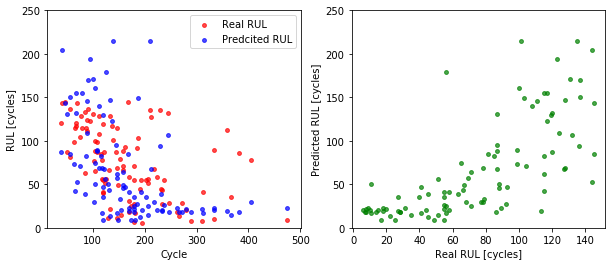

In [158]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_pred, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])

axes[1].scatter(y_real, y_pred, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])

axes[0].legend()
plt.show()

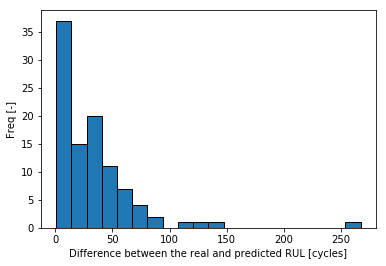

In [168]:
plt.hist(np.abs(y_real - y_pred), bins = 20, edgecolor='black')
plt.xlabel('Difference between the real and predicted RUL [cycles]')
plt.ylabel('Freq [-]')
plt.show()

In [180]:
print('Average score per UUT:', compute_score(y_real, y_pred) / 100)
print('Mean squared Error:', MSE(y_real, y_pred))
print('Median difference:', np.median(np.abs(y_real - y_pred)))

Average score per UUT: 3896986451.53
Mean squared Error: 4.92140773091
Median difference: 24.5439720154


# Support Vector Regression

In [160]:
model = svm.SVR()
model.fit(X, y)
y_pred_svm = model.predict(X_pred)

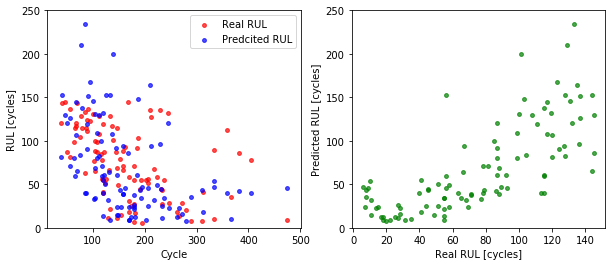

In [169]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_pred_svm, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])

axes[1].scatter(y_real, y_pred_svm, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])

axes[0].legend()
plt.show()

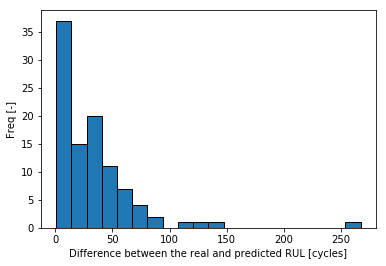

In [170]:
plt.hist(np.abs(y_real - y_pred), bins = 20, edgecolor='black')
plt.xlabel('Difference between the real and predicted RUL [cycles]')
plt.ylabel('Freq [-]')
plt.show()

In [179]:
print('Average score per UUT:', compute_score(y_real, y_pred_svm) / 100)
print('Mean squared Error:', MSE(y_real, y_pred_svm))
print('Median difference:', np.median(np.abs(y_real - y_pred_svm)))

Average score per UUT: 659.775909577
Mean squared Error: 3.53824793667
Median difference: 22.963349109
